# AstraZeneca Dataset: Predicting Compound Mechanism of Action

**N.B** The concentration column on this dataset is incorrect on the sqlite database from the Broad Institute. The concentrations are listed in $\mu$M, though the values have been truncated at the decimal point so that all sub $\mu$M concentrations are listed as zero.

**Description:** Dataset contains numerous morphological measurements extracted from cells treated with compounds. Data has been aggregated from single cell measurements to per-image medians.

Quick sandboxing at visualising and predicting mechanism of action of 32 compounds grouped into 12 mechanisms of action. The idea is to predict the mechanism of action of a compound based on the morphological effects of cells treated with the compound *in vitro*.

In [2]:
#####################
#     R kernel      #
#####################

library(ggplot2)
library(caret)
library(dplyr)
library(phenoDist)
library(Rtsne)
library(RColorBrewer)

# set plot size
options(repr.plot.width = 8, repr.plot.height = 6)
theme_set(theme_grey())
set.seed(12321)

df <- read.csv("/media/datastore_scott/tmp/df_tidy.csv")

In [3]:
# remove spurious metadata
df <- df[, c(3, 36:41, 43:ncol(df))]
# remove columns with near zero variance
df_tmp <- df[, - nearZeroVar(df)]
# get just feature data values
df_vals <- df_tmp[, get_featuredata(df_tmp)]
# calculate a correlation matrix
M <- cor(df_vals)
# remove pairs of highly correated values
df_red <- df_vals[, - findCorrelation(M)]
# add in unique identifier columns
df_red$Metadata_ImageNumber <- df$Metadata_ImageNumber
# get just metadata columns
df_metadata <- df_tmp[, - get_featuredata(df_tmp)]
# merge reduced feature data with metadata by ImageNumber column
df_new <- inner_join(df_metadata, df_red, by = "Metadata_ImageNumber")

# write reduced csv to file
write.csv(df_new, "df_reduced_featureset.csv", row.names = FALSE)

## Compounds in the dataset:

In [3]:
data.frame(compound = df_new$Metadata_Image_Metadata_Compound,
           MOA = df_new$Metadata_Image_Metadata_MOA) %>%
    distinct(compound)

,compound,MOA
1,cytochalasin B,Actin disruptors
2,cytochalasin D,Actin disruptors
3,latrunculin B,Actin disruptors
4,AZ258,Aurora kinase inhibitors
5,AZ841,Aurora kinase inhibitors
6,AZ-A,Aurora kinase inhibitors
7,mevinolin/lovastatin,Cholesterol-lowering
8,simvastatin,Cholesterol-lowering
9,chlorambucil,DNA damage
10,cisplatin,DNA damage


## Principal component analysis on the reduced feature data

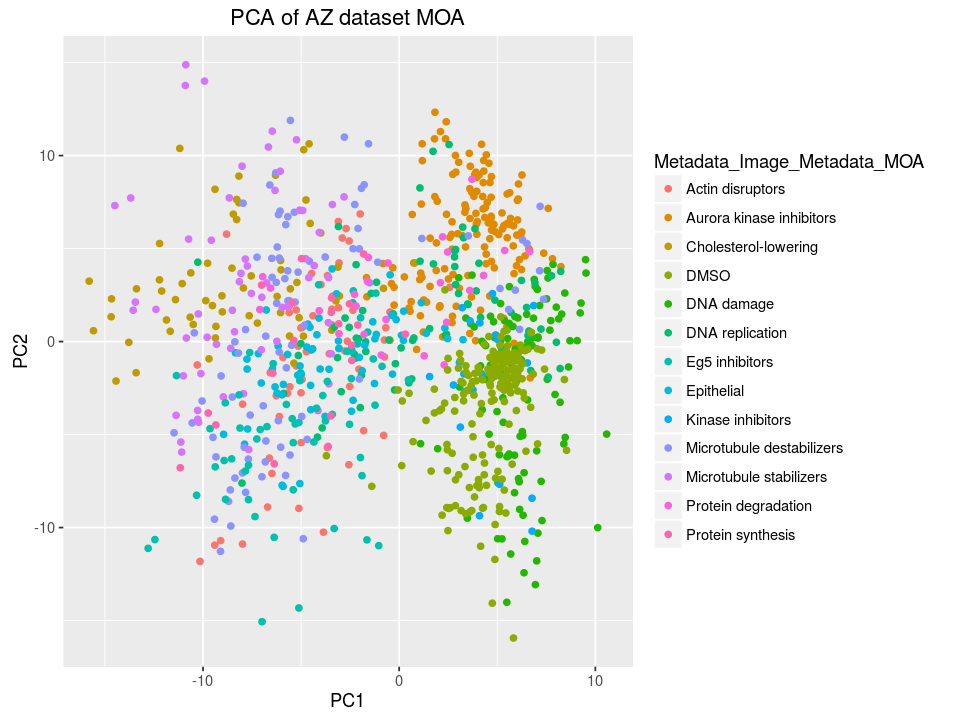

In [4]:
pca_df <- data.frame(df_new[, -get_featuredata(df_new)],
                     prcomp(df_new[, get_featuredata(df_new)])$x)
                 
ggplot(data = pca_df,
      aes(x = PC1, y = PC2, col = Metadata_Image_Metadata_MOA)) + 
    geom_point() + 
    ggtitle("PCA of AZ dataset MOA")


This is including all the concentrations for the data, would be better to separate the concentrations from one another.

When we do this we see that not all compounds were screened at each concentration. Not sure if this is because I have a reduced dataset or just a weird screening protocol by AZ.

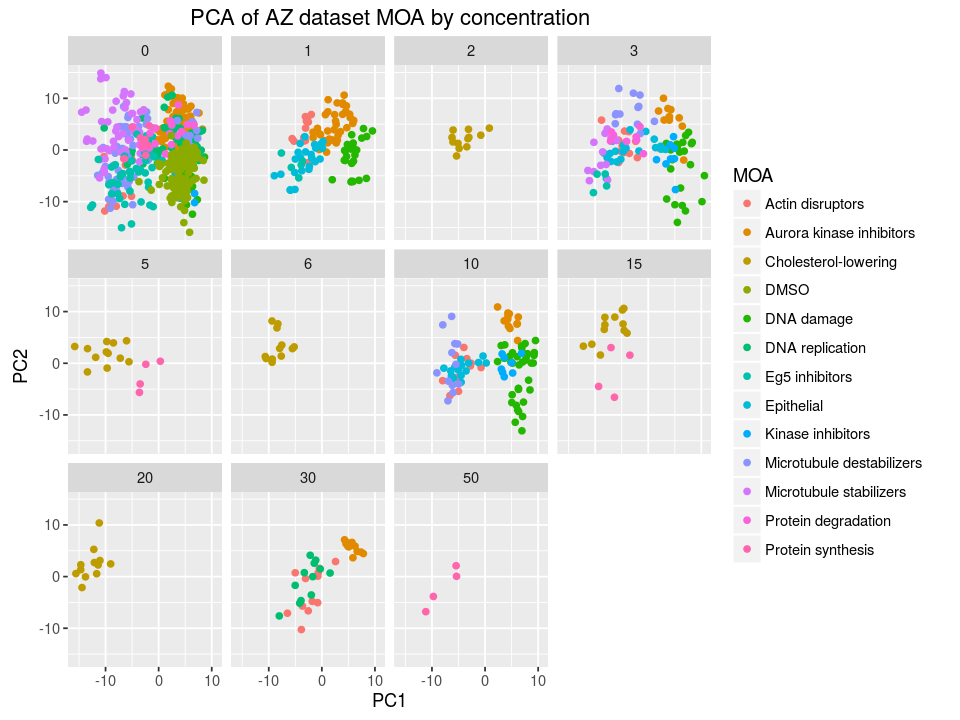

In [5]:
ggplot(data = pca_df,
      aes(x = PC1, y = PC2, col = Metadata_Image_Metadata_MOA)) + 
    geom_point() + 
    facet_wrap(~ Metadata_Image_Metadata_Concentration) + 
    ggtitle("PCA of AZ dataset MOA by concentration") + 
    scale_color_discrete(name = "MOA")

Can also plot each compound separately and colour them by MOA

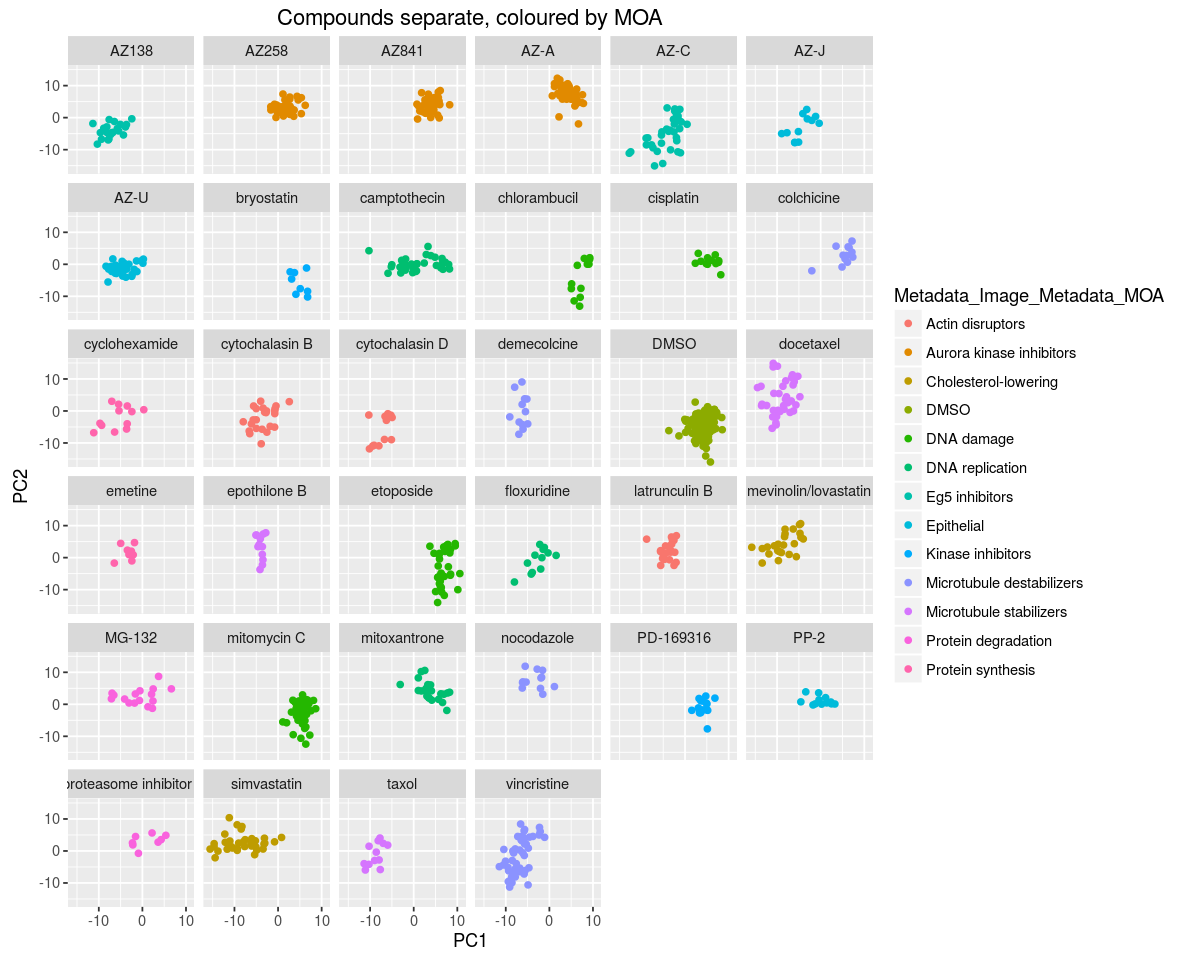

In [6]:
# increase plot size
options(repr.plot.width = 10, repr.plot.height = 8)

ggplot(data = pca_df,
      aes(x = PC1, y = PC2,
         col = Metadata_Image_Metadata_MOA)) + 
    geom_point() + 
    facet_wrap(~ Metadata_Image_Metadata_Compound) + 
    ggtitle("Compounds separate, coloured by MOA")

# Manifold mapping of compounds

Can use t-SNE (t-distribution stochastic neighbour embedding) to map points in an unsupervised manner. The idea behind t-SNE is that similar points will cluster together, we can then colour these points by compound mechanism of action.

## t-SNE
Trying both PCA'd data and using the normalised data after mapping via t-SNE, there's not much of a difference between PCA or non-PCA when run through the t-SNE algorithm, pretty much just a rotation of the mapping.



In [ ]:
tsne_out <- Rtsne(as.matrix(df_new[, get_featuredata(df_new)]),
                  pca = FALSE, perplexity = 8, theta = 0.1, max_iter = 1e4)
tsne_pca <- Rtsne(as.matrix(pca_df[, get_featuredata(pca_df)]),
                  pca = FALSE, perplexity = 8, theta = 0.1, max_iter = 1e4)

tsne_xy <- data.frame(tsne_out$Y,
                     compound = df_new$Metadata_Image_Metadata_Compound,
                     MOA = df_new$Metadata_Image_Metadata_MOA,
                     method = "normalised")

tsne_pca_df <- data.frame(tsne_pca$Y,
                         compound = pca_df$Metadata_Image_Metadata_Compound,
                         MOA = pca_df$Metadata_Image_Metadata_MOA,
                         method = "PCA")

tsne_both <- rbind(tsne_xy, tsne_pca_df)

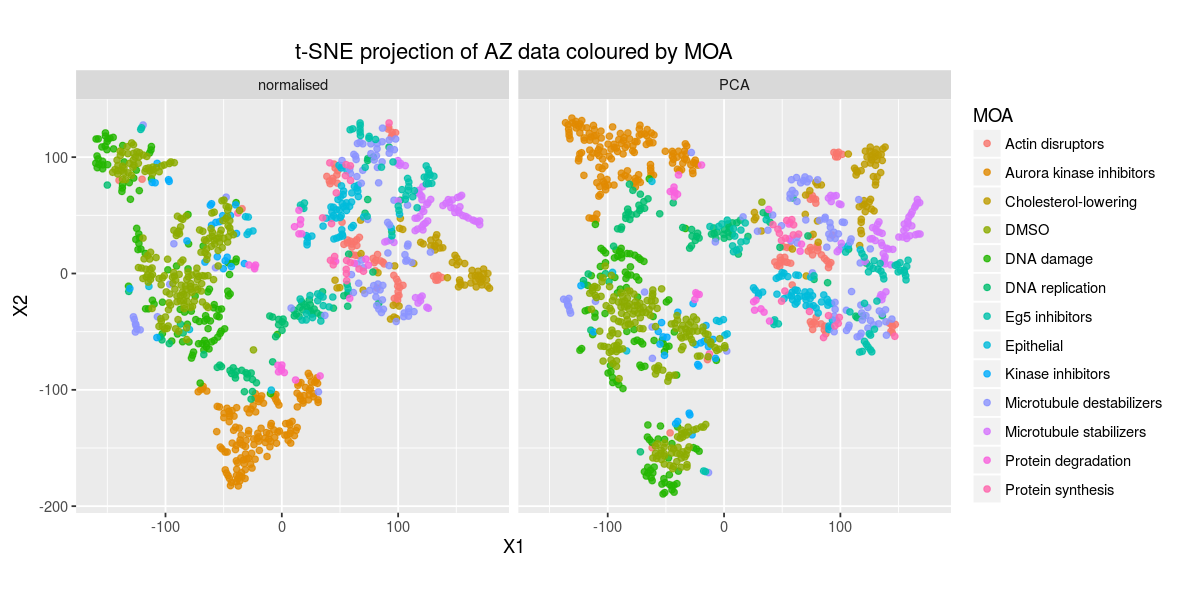

In [49]:
options(repr.plot.width = 10, repr.plot.height = 5)

ggplot(data = tsne_both, 
      aes(x = X1, y = X2, colour = MOA)) + 
    geom_point(alpha = 0.8) +
    facet_wrap(~ method) + 
    coord_fixed() +
    ggtitle("t-SNE projection of AZ data coloured by MOA")

# Grouping compounds by MOA

Want to see if compounds cluster by mechanism of action, this can be done done as a classification task to generate an accuracy score.

## Decision Tree Classifier

The `DescisionTreeClassifier` takes as input two arrays, an array `X` of size `[n_samples, n_features]` holding the training samples, and an array `Y` of integer values size `[n_samples]` holding the class labels for the training samples.

In [63]:
##################################
#   NB switch to python kernel   #
###################################

from __future__ import division, print_function
from sklearn import tree
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# set figure size
plt.rcParams['figure.figsize'] = 6, 5

# load reduced feature dataset
df = pd.read_csv("/media/datastore_scott/tmp/df_reduced_featureset.csv")

# remove DMSO as a compound
df = df[df.Metadata_Image_Metadata_Compound != "DMSO"]

Need to convert the MOA labels into integers, and then have a separate array for features and labels.

For the first attempt I will use the entire dataset to train to model.

In [64]:
# split into arrays of features and labels

# feature labels
feature_names = df["Metadata_Image_Metadata_MOA"]
feature_label = pd.Categorical(feature_names).codes

# make an array of feature data
feature_data = np.array(df[df.columns[5:]])

# train classifier
clf = tree.DecisionTreeClassifier()
clf = clf.fit(feature_data, feature_label)

# predict labels
predicted_labels = clf.predict(feature_data)

# determine classification accuracy
correct = feature_label == predicted_labels
perc_correct = sum(correct) / len(correct) * 100
print("Percentage accuracy = ", perc_correct)

Percentage accuracy =  100.0


Clearly it's not correct to predict classes on the same data you trained to model with, so this time we will use random sampling to train the classifier on a proportion (70%) of the data, and withold the 30% as the test data.

In [65]:
data_train, data_test, label_train, label_test = train_test_split(feature_data,
                                                                  feature_label,
                                                                  test_size=0.3,
                                                                  random_state=123)

# create classifier model from training data
d_tree = tree.DecisionTreeClassifier()
d_tree = d_tree.fit(data_train, label_train)

# predict labels on test data
predicted_labels_test = d_tree.predict(data_test)
correct = predicted_labels_test == label_test
perc_correct = sum(correct) / len(correct) * 100
print("Percentage accuracy = ", perc_correct)

Percentage accuracy =  67.2413793103


This result is much more probable, although this is from a single random sample. Ideally we want to sample and train many times and determine the average classifying accuracy (bootstrapping).

In [66]:
# probably a built-in method to do this in sklearn, but screw it, we'll make our own

def bootstrap_AZ_dTree(n_samples, test_prop = 0.3):
    acc = []

    for i in range(1, n_samples):
        data_train, data_test, label_train, label_test = train_test_split(feature_data,
                                                                          feature_label,
                                                                          test_size=test_prop)

        # create classifier model from training data
        d_tree = tree.DecisionTreeClassifier(max_depth=15)
        d_tree = d_tree.fit(data_train, label_train)

        # predict labels on test data
        predicted_labels_test = d_tree.predict(data_test)
        correct = predicted_labels_test == label_test
        perc_correct = sum(correct) / len(correct) * 100
        acc.append(perc_correct)
        
    return acc

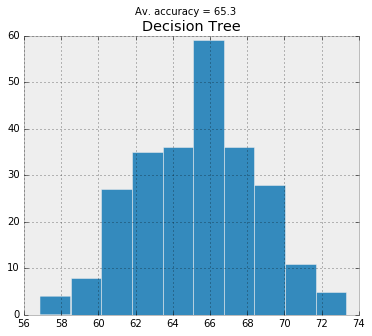

In [67]:
acc_out = bootstrap_AZ_dTree(250, test_prop = 0.33)

plt.hist(acc_out)
plt.suptitle("Av. accuracy = %.1f" %np.mean(acc_out))
plt.title("Decision Tree")
plt.show()

Looks like the accuracy is relatively stable around 64% - 70%, which is just about acceptable but isn't great. We have increased the accuracy by ~ 2% by limiting the max depth of the decision tree, presumably this has increased classification accuracy by limiting overfitting on the training data.

## Random Forest classifiers

A random forest is an ensemble of decision trees, with the idea that many weak classifiers can out-perform a single well trained classifier.

We see that is outperforms the decision tree classifier at predicting mechanism of action, with the default parameters the classification accuracy is ~75%. If we bump up the number of trees to 200 (from 10), we get a 10% increase in accuracy.

In [68]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score


def r_forest_AZ(): 
    data_train, data_test, label_train, label_test = train_test_split(feature_data,
                                                                  feature_label,
                                                                  test_size=0.33)

    r_forest = RandomForestClassifier(n_estimators = 200, n_jobs=-1)
    r_forest = r_forest.fit(data_train, label_train)

    predicted_labels = r_forest.predict(data_test)

    correct = predicted_labels == label_test
    perc_correct = sum(correct) / len(correct) * 100
    return(perc_correct)

acc = []
for i in range(1, 250):
    out = r_forest_AZ()
    acc.append(out)

print("Random Forest Classification Accuracy = ", np.mean(acc), "%")

Random Forest Classification Accuracy =  85.1216631231 %


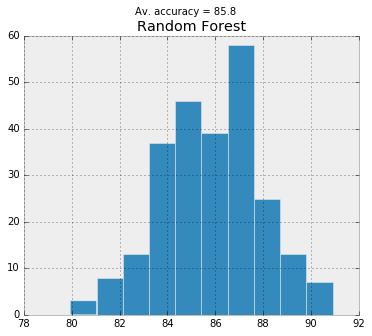

In [13]:
plt.hist(acc)
plt.suptitle("Av. accuracy = %.1f" %np.mean(acc))
plt.title("Random Forest")
plt.show()

A better way to visualise this would be a confusion matrix, we can then see if certain mechanistic classes are more accurately classified than others.

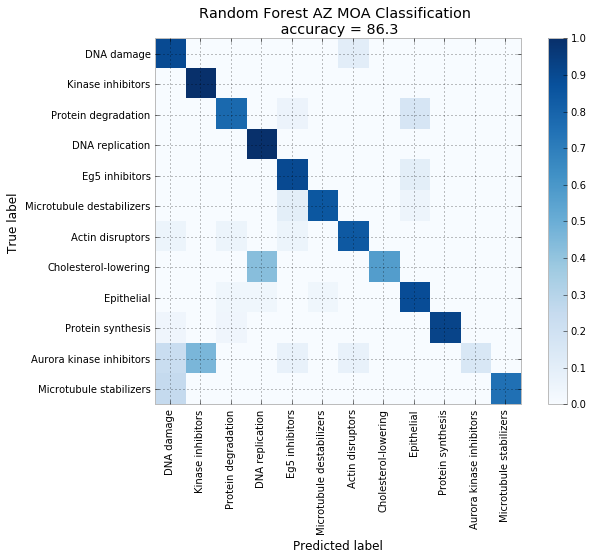

In [71]:
# function to plot confusion matrix from the sklearn docs
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

# is set() ruining the order of my features and their labels?

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    tick_marks = np.arange(len(set(feature_names)))
    plt.xticks(tick_marks, set(feature_names), rotation = 90)
    plt.yticks(tick_marks, set(feature_names))
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
data_train, data_test, label_train, label_test = train_test_split(
    feature_data,
    feature_label,
    test_size=0.33)

r_forest = RandomForestClassifier(n_estimators = 200, n_jobs=-1)
r_forest = r_forest.fit(data_train, label_train)
predicted_labels = r_forest.predict(data_test)

correct = predicted_labels == label_test
perc_correct = sum(correct) / len(correct) * 100

cm = confusion_matrix(label_test, predicted_labels)

# normalise confusion matrix to account for different sized groups
norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8,6))
plot_confusion_matrix(norm_cm,
                      title = "Random Forest AZ MOA Classification \n accuracy = %.1f"
                      %perc_correct )
plt.show()

From this confusion matrix, some of the mis-classified compounds makes sense from a biological point-of-view. i.e the Aurora kinase inhibitors are often mis-classified as kinase inhbitors, or DNA damaging agents - likely due to their obvious effects on nuclear morphology.

## Nearest Neighbour Classification

Unsupervised nearest neighbour classification, with closest nearest neighbour (KNN = 1).
Naive approach is not as accurate as the random forest.

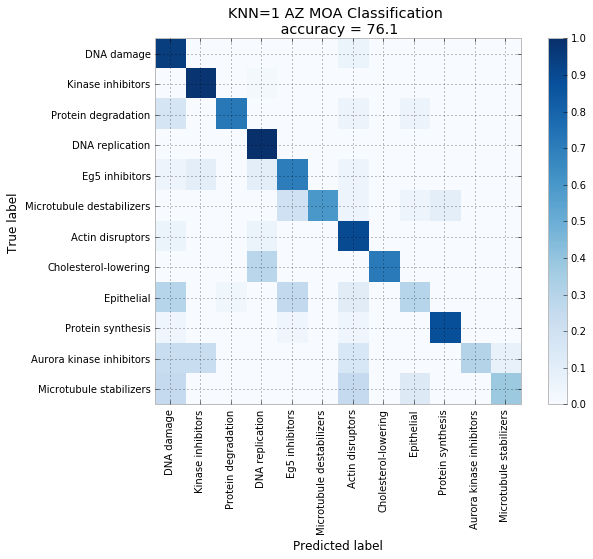

In [93]:
from sklearn import neighbors

clf = neighbors.KNeighborsClassifier(n_neighbors = 1)
clf.fit(data_train, label_train)

pred_labels = clf.predict(data_test)
correct = pred_labels == label_test
perc_correct = sum(correct) / len(correct) * 100

cm = confusion_matrix(label_test, pred_labels)
norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8,6))
plot_confusion_matrix(norm_cm,
                      title = "KNN=1 AZ MOA Classification \n accuracy = %.1f"
                      %perc_correct)
plt.show()